# Prophet 

* https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random
import torch

from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from prophet import Prophet

## Setup

In [4]:
DATASET_PATH = 'https://raw.githubusercontent.com/magistery-tps/time-series-tp/master/datasets/consumo_energetico_diario.csv'
dataset = pd.read_csv(DATASET_PATH,parse_dates=['dia'])
dataset.columns = dataset.columns.str.lower()

dataset.rename(columns={'dia':'ds','mwh':'y'},inplace=True)

dataset.head()

,ds,y,tmp
0,2005-12-01,81445.928,18.104167
1,2005-12-02,81749.888,17.904167
2,2005-12-03,72134.590,19.562500
3,2005-12-04,63452.628,18.854167
4,2005-12-05,81508.078,21.941667


In [5]:
DATASET_PATH= 'https://raw.githubusercontent.com/magistery-tps/time-series-tp/leandro/datasets/regresores_v1.csv'
dataset_regresores = pd.read_csv(DATASET_PATH,parse_dates=['fecha'])
dataset_regresores.columns = dataset_regresores.columns.str.lower()
dataset_regresores.drop(['dia'], axis=1,inplace=True)
dataset_regresores.rename(columns={'fecha':'ds'},inplace=True)

dataset_regresores=dataset_regresores[['ds','precio_kwh_norm_new']]

dataset=dataset.merge(dataset_regresores, how='left')
dataset

,ds,y,tmp,precio_kwh_norm_new
0,2005-12-01,81445.928000,18.104167,NaN
1,2005-12-02,81749.888000,17.904167,NaN
2,2005-12-03,72134.590000,19.562500,NaN
3,2005-12-04,63452.628000,18.854167,NaN
4,2005-12-05,81508.078000,21.941667,NaN
...,...,...,...,...
5717,2021-07-27,163043.900635,8.475000,0.072498
5718,2021-07-28,172692.328857,7.916667,0.072429
5719,2021-07-29,167475.483154,8.195833,0.072360
5720,2021-07-30,157115.490479,9.679167,0.072291


## Functions

In [6]:
def predict(model, y_true_df, times):
    sns.set(rc = {'figure.figsize':(10,6)})

    y_true_df = y_true_df.head(times)

    y_pred_df = model.predict(y_true_df[['ds']])

    predictions_df = y_true_df.merge(y_pred_df, on='ds')
    predictions_df = predictions_df[['ds', 'y', 'yhat']]
    predictions_df = predictions_df.sort_values(by='ds',ascending=True)
    
    plot(
        predictions_df.yhat.values,
        predictions_df.y.values
    )
    
    
    model.plot(y_pred_df)

## Preprocessing

Acoto desde 2012 en adelante ya que las oscilaciones se ven de amplitud mas constante. Al observar los años 2006-2011 parecen ir creciendo la tendencia de consumo de energía.

In [7]:
tiempo_ini='12-31-2005' #serie completa

train_set=dataset[(dataset.ds>tiempo_ini)&(dataset.ds<'1-1-2020')] #ultimo dia train 31/12/2019, 
train_set.reset_index(inplace=True)

test_set=dataset[(dataset.ds>='1-1-2020')] #ultimo dia train 31/12/2019
test_set.reset_index(inplace=True)

N_test=len(test_set)

train_set=train_set[train_set.ds>='03-06-2012'] #ultimo dia train 31/12/2019
train_set.reset_index(inplace=True)

dataset_periodo=dataset[dataset.ds>='03-06-2012']
dataset_periodo.reset_index(inplace=True)

## Model

In [8]:
model = Prophet(mcmc_samples=100) #mcmc_samples=300 #full bayesian
model.add_regressor('tmp',mode='additive')
model.add_regressor('precio_kwh_norm_new',mode='additive')
model.add_country_holidays(country_name='Argentina')

model.fit(train_set)

13:14:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:15:20 - cmdstanpy - INFO - CmdStan done processing.
13:15:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/bld/prophet_1656454859393/work/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/bld/prophet_1656454859393/work/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/bld/prophet_1656454859393/work/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/bld/prophet_1656454859393/work/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/bld/prophet_1656454859393/work/stan/prophet.stan', line 

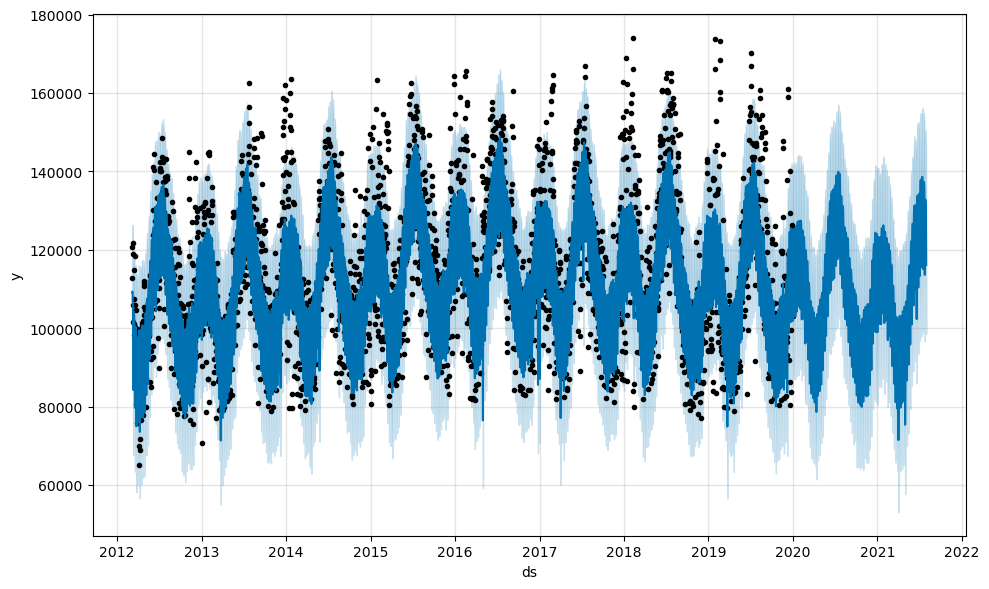

In [9]:
future = model.make_future_dataframe(periods=N_test)
future['tmp']=dataset_periodo.tmp
future['precio_kwh_norm_new']=dataset_periodo.precio_kwh_norm_new

forecast = model.predict(future)
fig=model.plot(forecast)

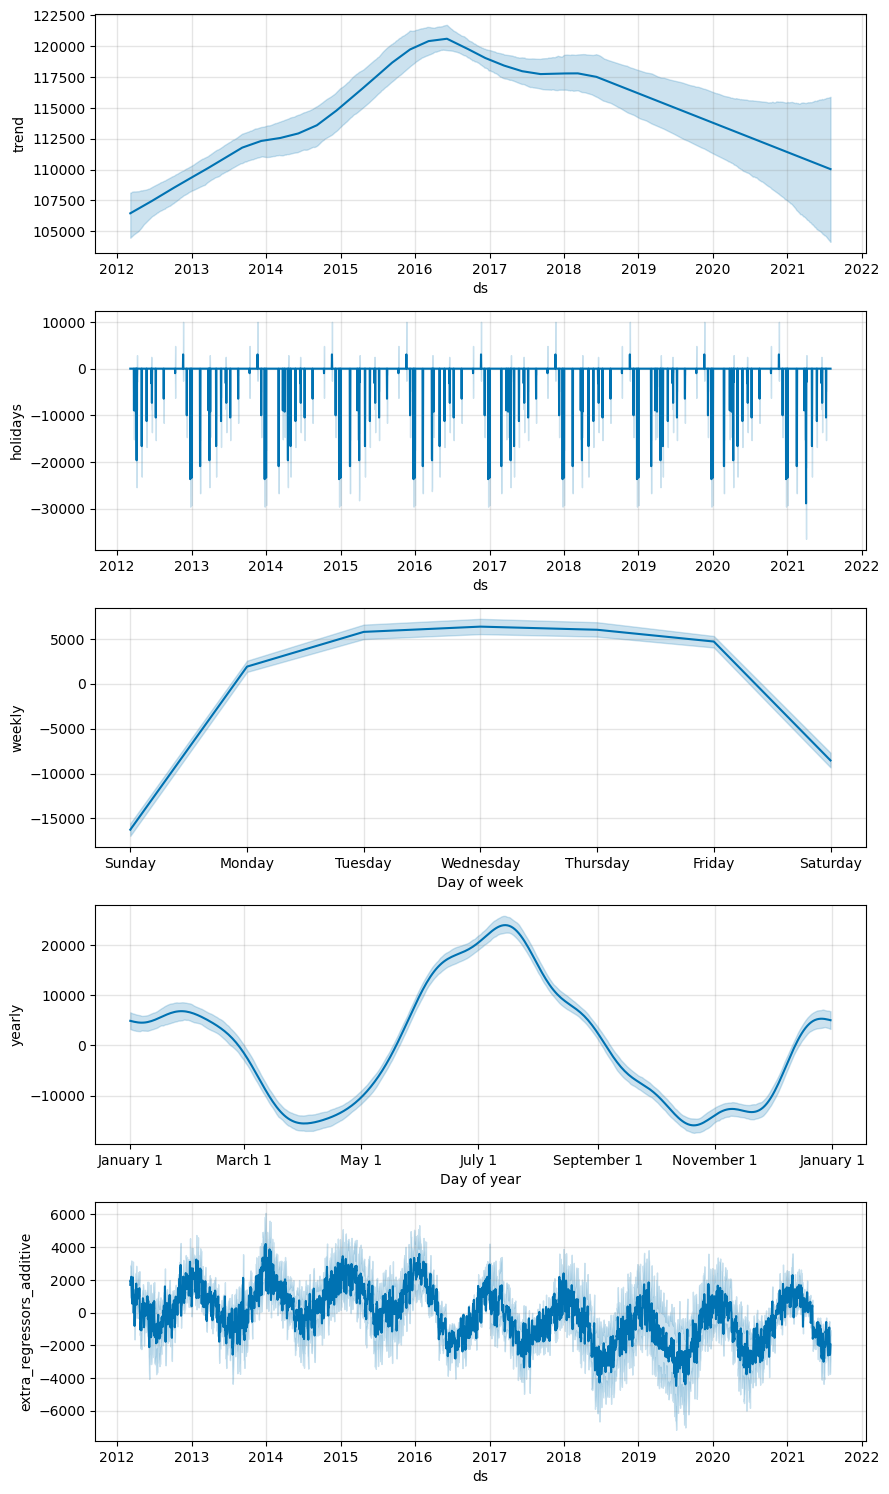

In [10]:
fig=model.plot_components(forecast)

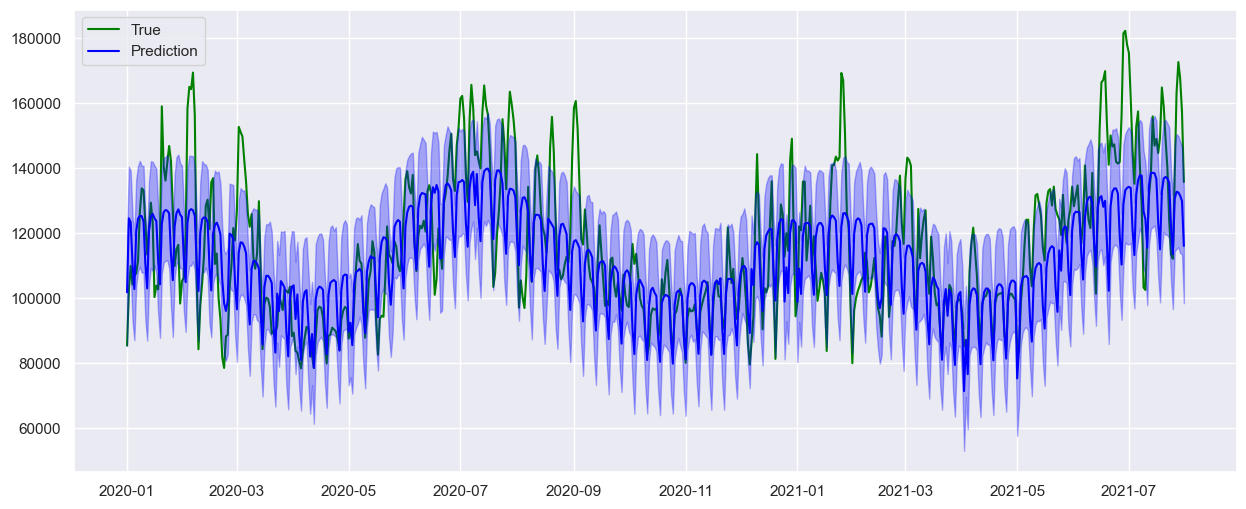

In [11]:
N=len(forecast)
y_fore=forecast['yhat']
y_fore_future=pd.DataFrame(y_fore[-N_test:])
y_fore_train=pd.DataFrame(y_fore[0:N-N_test])


sns.set(rc = {'figure.figsize':(15,6)})
sns.set_style("darkgrid")
plt.plot(test_set.ds,test_set.y,color='green',label="True")
plt.plot(test_set.ds,y_fore_future,color='blue', label="Prediction")
plt.fill_between(test_set.ds,forecast.yhat_lower.values[-N_test:], 
                 forecast.yhat_upper.values[-N_test:], alpha=0.3, color='blue',zorder=3)
plt.legend()
plt.show()

In [12]:
mse = mean_squared_error(train_set.y, y_fore_train)
mae = mean_absolute_error(train_set.y, y_fore_train)
mape = mean_absolute_percentage_error(train_set.y, y_fore_train)
print('Train - Error cuadratico medio: ', mse)
print('Train - Error absoluto medio: ',mae)
print('Train - Error porcentual abs:',mape)

mse = mean_squared_error(test_set.y, y_fore_future)
mae = mean_absolute_error(test_set.y, y_fore_future)
mape = mean_absolute_percentage_error(test_set.y, y_fore_future)
print('Test - Error cuadratico medio: ', mse)
print('Test - Error absoluto medio: ',mae)
print('Test - Error porcentual abs:',mape)

Train - Error cuadratico medio:  153713063.49754074
Train - Error absoluto medio:  9378.011440239896
Train - Error porcentual abs: 0.08104235328329024
Test - Error cuadratico medio:  256499493.96387354
Test - Error absoluto medio:  12398.586245069107
Test - Error porcentual abs: 0.10239280635117887


In [13]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3435 entries, 0 to 3434
Data columns (total 82 columns):
 #   Column                                                                                                                                 Non-Null Count  Dtype         
---  ------                                                                                                                                 --------------  -----         
 0   ds                                                                                                                                     3435 non-null   datetime64[ns]
 1   trend                                                                                                                                  3435 non-null   float64       
 2   yhat_lower                                                                                                                             3435 non-null   float64       
 3   yhat_upper                       

### HDD and CDD indices

Heating/Cooling Degree Days measure the amount of heating or cooling necessary at your property. Degree days are measured relative to a base of 65°F (18°C). Above 18°C it is assumed that your property will need to have cooling, and below 18°C it is assumed that your property will need to have heating.

The bases to terminate whether a specific day is a heating degree day or a cooling degree day is the daily average temperature TM (add the high and low temperatures and divide it by two). Each day with a mean temperature below 18°C is counted as one heating degree day. The cooling degree day is the summer counterpart of the heating degree day.

Heating degree days are calculated over a period of time by adding up the differences between each day's mean daily temperature and the temperature of 18°C (or 65°F). For any temperature above 18°C the building is assumed not to need any heating. For example three winter days in a row with average temperatures of 4°C, -2°C and -4°C totals to 56 HDD. Accordingly, three summer days of 26°C, 28°C, and 30°C totals to 30 CDD.

Referencia general:
https://www.weatheronline.co.uk/faq/hdd_cdd.html

otras ref: https://www.e-education.psu.edu/egee102/node/2055

https://energystar-mesa.force.com/PortfolioManager/s/article/What-are-Heating-Degree-Days-HDD-Cooling-Degree-Days-CDD-1600088536891

Elijo 18°C. Se pueden probar otros valores.

In [14]:
t_base=18
dataset['CDD']=dataset['tmp'].apply(lambda x: x - t_base if x >t_base else 0)
dataset['HDD']=dataset['tmp'].apply(lambda x: t_base - x if x <t_base else 0)

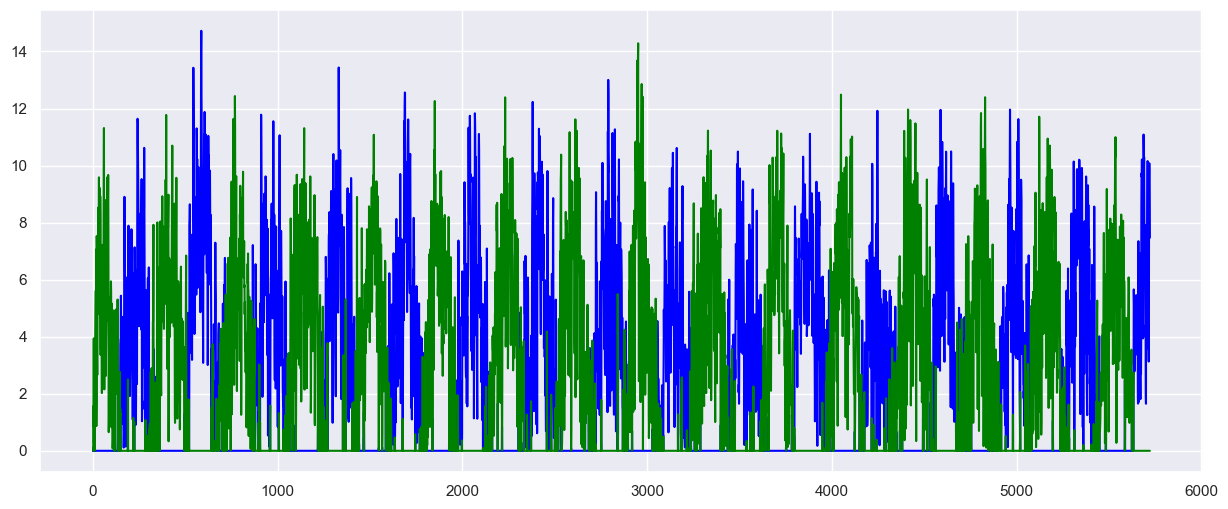

In [15]:
plt.plot(dataset.HDD,color='blue')
plt.plot(dataset.CDD,color='green')

In [16]:
train_set=dataset[(dataset.ds>'03-06-2012')&(dataset.ds<'1-1-2020')] #ultimo dia train 31/12/2019, 
train_set.reset_index(inplace=True)

test_set=dataset[(dataset.ds>='1-1-2020')] #ultimo dia train 31/12/2019
test_set.reset_index(inplace=True)

N_test=len(test_set)

dataset=dataset[(dataset.ds>'03-06-2012')] 
dataset.reset_index(inplace=True)

In [17]:
model = Prophet() #mcmc_samples=300 #full bayesian
model.add_regressor('HDD',mode='additive')
model.add_regressor('CDD',mode='additive')

model.fit(train_set)

13:15:38 - cmdstanpy - INFO - Chain [1] start processing
13:15:39 - cmdstanpy - INFO - Chain [1] done processing


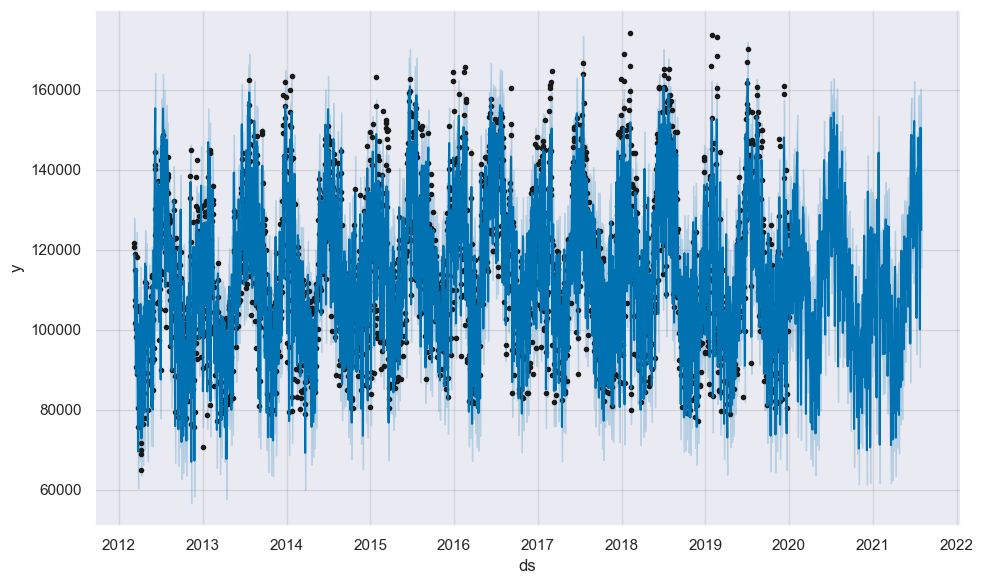

In [18]:
future = model.make_future_dataframe(periods=N_test)
future['HDD']=dataset.HDD
future['CDD']=dataset.CDD
forecast = model.predict(future)
fig=model.plot(forecast)

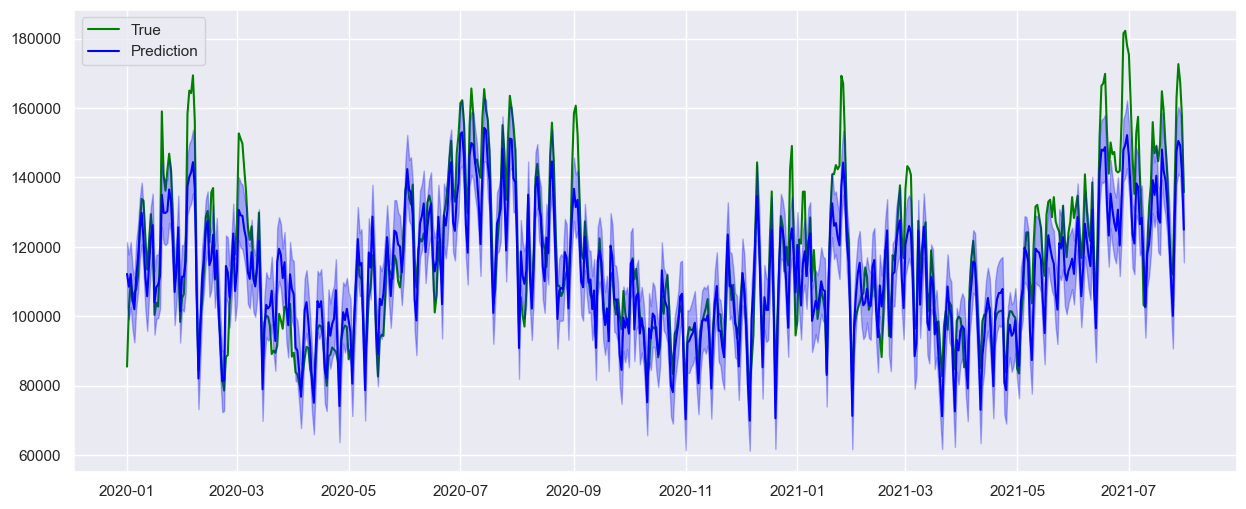

In [19]:
N=len(forecast)
y_fore=forecast['yhat']
y_fore_future=pd.DataFrame(y_fore[-N_test:])
y_fore_train=pd.DataFrame(y_fore[0:N-N_test])


sns.set(rc = {'figure.figsize':(15,6)})
sns.set_style("darkgrid")
plt.plot(test_set.ds,test_set.y,color='green',label="True")
plt.plot(test_set.ds,y_fore_future,color='blue', label="Prediction")
plt.fill_between(test_set.ds,forecast.yhat_lower.values[-N_test:], 
                 forecast.yhat_upper.values[-N_test:], alpha=0.3, color='blue',zorder=3)
plt.legend()
plt.show()

In [20]:
mse = mean_squared_error(train_set.y, y_fore_train)
mae = mean_absolute_error(train_set.y, y_fore_train)
mape = mean_absolute_percentage_error(train_set.y, y_fore_train)
print('Train - Error cuadratico medio: ', mse)
print('Train - Error absoluto medio: ',mae)
print('Train - Error porcentual abs:',mape)

mse = mean_squared_error(test_set.y, y_fore_future)
mae = mean_absolute_error(test_set.y, y_fore_future)
mape = mean_absolute_percentage_error(test_set.y, y_fore_future)
print('Test - Error cuadratico medio: ', mse)
print('Test - Error absoluto medio: ',mae)
print('Test - Error porcentual abs:',mape)

Train - Error cuadratico medio:  51850686.34548876
Train - Error absoluto medio:  5512.230287637721
Train - Error porcentual abs: 0.04950999224294365
Test - Error cuadratico medio:  105269768.99279046
Test - Error absoluto medio:  8010.49268472568
Test - Error porcentual abs: 0.06698361955437253
